# 3. 特徴量エンジニアリング

インフルエンザ患者数を予測するための特徴量を作成します。

## 3.1 ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print('ライブラリのインポート完了')

ライブラリのインポート完了


## 3.2 データの読み込み

In [2]:
# 前処理済みデータを読み込み
df_flu = pd.read_csv('../data/processed/influenza_hokkaido_2015-2024.csv', parse_dates=['date'])
df_weather = pd.read_csv('../data/processed/weather_sapporo_2015-2024.csv', parse_dates=['date'])

print(f'インフルエンザデータ: {df_flu.shape}')
print(f'気象データ: {df_weather.shape}')

df_flu.head()

インフルエンザデータ: (522, 4)
気象データ: (3653, 3)


,date,year,week,cases_per_sentinel
0,2015-01-05,2015,1,25.73
1,2015-01-12,2015,2,20.29
2,2015-01-19,2015,3,14.48
3,2015-01-26,2015,4,14.86
4,2015-02-02,2015,5,17.86


## 3.3 気象データの週次集計

日別の気象データを週次に集計して、インフルエンザデータと同じ粒度にします。

In [3]:
# 週番号を追加（ISO週番号）
df_weather['year'] = df_weather['date'].dt.isocalendar().year
df_weather['week'] = df_weather['date'].dt.isocalendar().week

# 週次で平均を取る
df_weather_weekly = df_weather.groupby(['year', 'week']).agg({
    'avg_temp': 'mean',
    'avg_humidity': 'mean',
    'date': 'first'  # その週の最初の日付を代表値として残す
}).reset_index()

print(f'週次気象データ: {df_weather_weekly.shape}')
df_weather_weekly.head(10)

週次気象データ: (523, 5)


,year,week,avg_temp,avg_humidity,date
0,2015,1,-4.300000,62.000000,2015-01-01
1,2015,2,-0.571429,73.857143,2015-01-05
2,2015,3,-1.528571,70.857143,2015-01-12
3,2015,4,-1.485714,74.571429,2015-01-19
4,2015,5,-1.057143,65.714286,2015-01-26
5,2015,6,-2.728571,66.571429,2015-02-02
6,2015,7,-2.685714,68.285714,2015-02-09
7,2015,8,1.171429,66.285714,2015-02-16
8,2015,9,1.085714,71.857143,2015-02-23
9,2015,10,1.671429,74.285714,2015-03-02


## 3.4 データのマージ

インフルエンザデータと気象データを結合します。

In [4]:
# year と week でマージ
df = df_flu.merge(
    df_weather_weekly[['year', 'week', 'avg_temp', 'avg_humidity']], 
    on=['year', 'week'], 
    how='left'
)

print(f'マージ後のデータ: {df.shape}')
print(f'欠損値:\n{df.isnull().sum()}')

df.head(10)

マージ後のデータ: (522, 6)
欠損値:
date                  0
year                  0
week                  0
cases_per_sentinel    0
avg_temp              0
avg_humidity          0
dtype: int64


,date,year,week,cases_per_sentinel,avg_temp,avg_humidity
0,2015-01-05,2015,1,25.73,-4.300000,62.000000
1,2015-01-12,2015,2,20.29,-0.571429,73.857143
2,2015-01-19,2015,3,14.48,-1.528571,70.857143
3,2015-01-26,2015,4,14.86,-1.485714,74.571429
4,2015-02-02,2015,5,17.86,-1.057143,65.714286
5,2015-02-09,2015,6,17.34,-2.728571,66.571429
6,2015-02-16,2015,7,14.81,-2.685714,68.285714
7,2015-02-23,2015,8,10.82,1.171429,66.285714
8,2015-03-02,2015,9,9.46,1.085714,71.857143
9,2015-03-09,2015,10,7.19,1.671429,74.285714


## 3.5 特徴量の作成

予測に使う特徴量を作成します。

In [5]:
# データをコピー
df_features = df.copy()

# 1. ラグ特徴量（過去の患者数）
df_features['lag_1'] = df_features['cases_per_sentinel'].shift(1)  # 1週前
df_features['lag_2'] = df_features['cases_per_sentinel'].shift(2)  # 2週前
df_features['lag_4'] = df_features['cases_per_sentinel'].shift(4)  # 4週前

# 2. 移動平均
df_features['rolling_mean_4'] = df_features['cases_per_sentinel'].rolling(window=4, min_periods=1).mean()

# 3. 季節性（週番号）
# ※すでにweekがあるのでそのまま使用

# 4. 月
df_features['month'] = df_features['date'].dt.month

# 5. 学校休暇フラグ（北海道の場合）
# 夏休み: 7月下旬～8月中旬 (7-8月)
# 冬休み: 12月下旬～1月中旬 (12-1月)
# 春休み: 3月下旬～4月上旬 (3-4月)
df_features['is_school_holiday'] = df_features['month'].isin([7, 8, 12, 1, 3, 4]).astype(int)

# 6. 前年同週の患者数
df_features['lag_52'] = df_features['cases_per_sentinel'].shift(52)

print('特徴量を作成しました')
print(f'\n列数: {len(df_features.columns)}')
print(f'列名: {df_features.columns.tolist()}')

特徴量を作成しました

列数: 13
列名: ['date', 'year', 'week', 'cases_per_sentinel', 'avg_temp', 'avg_humidity', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4', 'month', 'is_school_holiday', 'lag_52']


In [6]:
# 欠損値の確認
print('=== 欠損値 ===')
print(df_features.isnull().sum())

# 最初の数行（ラグがあるので欠損）を除外
df_features_clean = df_features.dropna()

print(f'\n欠損値除外後: {df_features_clean.shape}')
df_features_clean.head()

=== 欠損値 ===
date                   0
year                   0
week                   0
cases_per_sentinel     0
avg_temp               0
avg_humidity           0
lag_1                  1
lag_2                  2
lag_4                  4
rolling_mean_4         0
month                  0
is_school_holiday      0
lag_52                52
dtype: int64

欠損値除外後: (470, 13)


,date,year,week,cases_per_sentinel,avg_temp,avg_humidity,lag_1,lag_2,lag_4,rolling_mean_4,month,is_school_holiday,lag_52
52,2016-01-04,2015,53,2.73,-2.057143,64.428571,2.35,1.57,0.74,1.9375,1,1,25.73
53,2016-01-04,2016,1,4.89,-2.985714,63.000000,2.73,2.35,1.10,2.8850,1,1,20.29
54,2016-01-11,2016,2,7.23,-5.342857,65.428571,4.89,2.73,1.57,4.3000,1,1,14.48
55,2016-01-18,2016,3,12.25,-3.142857,68.285714,7.23,4.89,2.35,6.7750,1,1,14.86
56,2016-01-25,2016,4,27.45,-4.100000,63.000000,12.25,7.23,2.73,12.9550,1,1,17.86


## 3.6 相関分析

目的変数（cases_per_sentinel）と各特徴量の相関を確認します。

=== 目的変数との相関係数 ===
cases_per_sentinel    1.000000
lag_1                 0.944232
rolling_mean_4        0.913557
lag_2                 0.823299
lag_4                 0.554496
lag_52                0.423018
is_school_holiday     0.107389
year                 -0.030777
date                 -0.050116
avg_humidity         -0.119786
month                -0.172089
week                 -0.173288
avg_temp             -0.530934
Name: cases_per_sentinel, dtype: float64


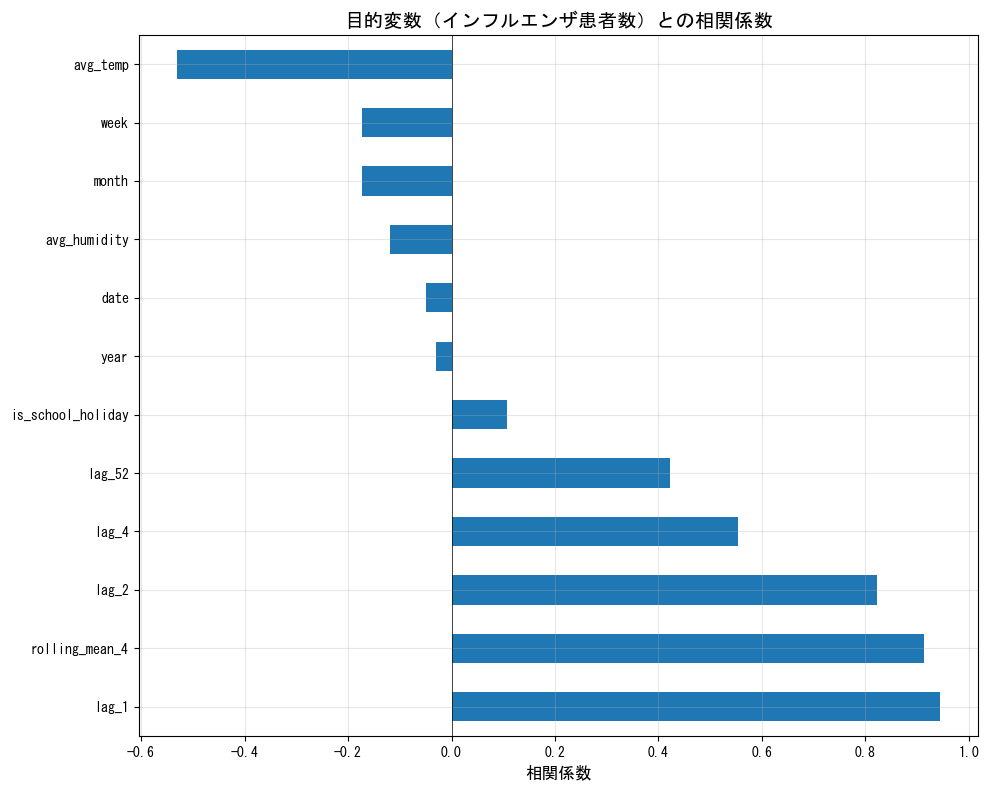

In [7]:
# 相関係数を計算
correlation = df_features_clean.corr()['cases_per_sentinel'].sort_values(ascending=False)

print('=== 目的変数との相関係数 ===')
print(correlation)

# 可視化
plt.figure(figsize=(10, 8))
correlation.drop('cases_per_sentinel').plot(kind='barh')
plt.title('目的変数（インフルエンザ患者数）との相関係数', fontsize=14)
plt.xlabel('相関係数', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/feature_correlation.png', dpi=300)
plt.show()

## 3.7 相関マトリックスのヒートマップ

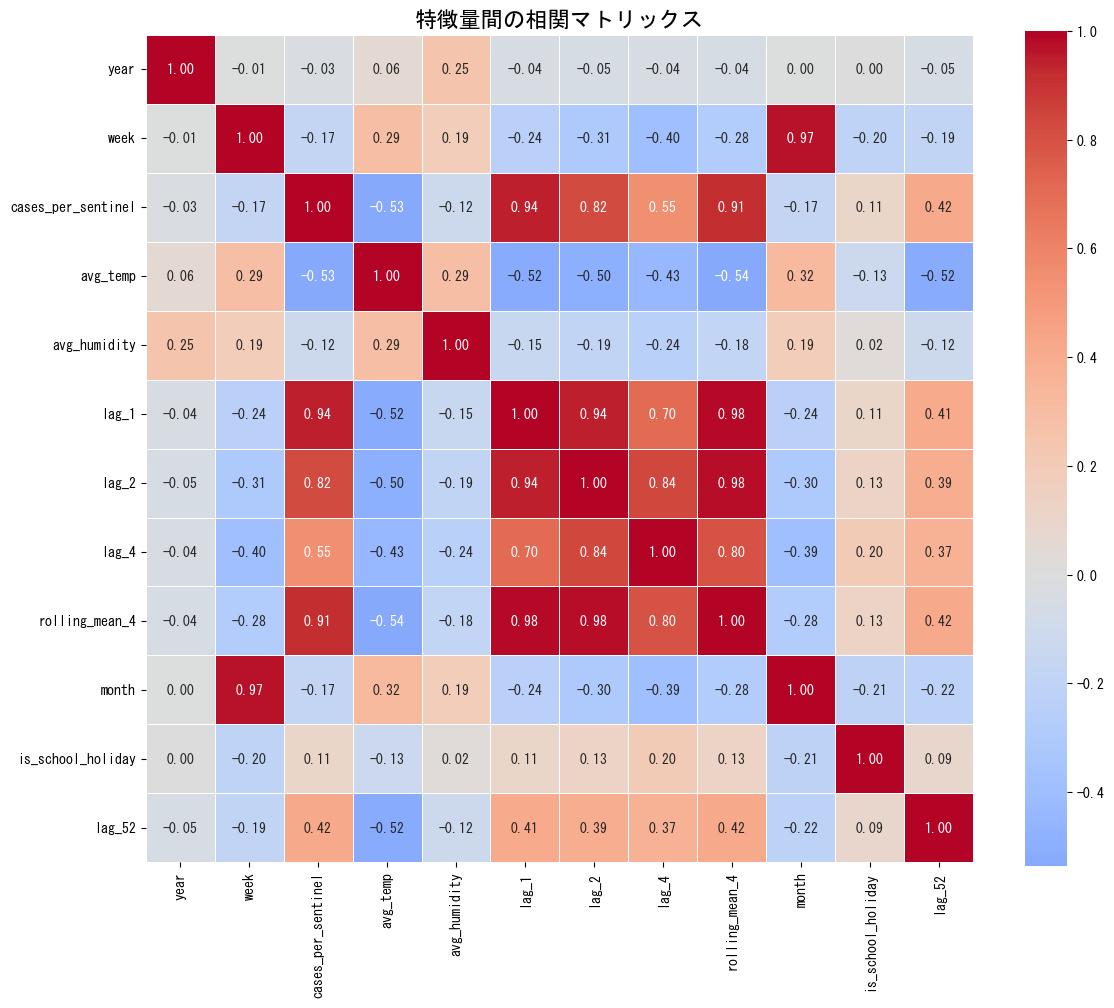

In [8]:
# 数値列のみ抽出
numeric_cols = df_features_clean.select_dtypes(include=[np.number]).columns

# 相関マトリックス
corr_matrix = df_features_clean[numeric_cols].corr()

# ヒートマップ
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('特徴量間の相関マトリックス', fontsize=16)
plt.tight_layout()
plt.savefig('../outputs/figures/correlation_matrix.png', dpi=300)
plt.show()

## 3.8 学習データとテストデータの分割

- 学習データ: 2015-2019年（コロナ前）
- テストデータ: 2019-2020シーズン前半

In [9]:
# 2020年3月1日以前を学習データ、それ以降をテストデータとする
split_date = '2020-03-01'

train = df_features_clean[df_features_clean['date'] < split_date].copy()
test = df_features_clean[df_features_clean['date'] >= split_date].copy()

print(f'学習データ: {train.shape} ({train["date"].min()} ~ {train["date"].max()})')
print(f'テストデータ: {test.shape} ({test["date"].min()} ~ {test["date"].max()})')

学習データ: (217, 13) (2016-01-04 00:00:00 ~ 2020-02-24 00:00:00)
テストデータ: (253, 13) (2020-03-02 00:00:00 ~ 2024-12-23 00:00:00)


## 3.9 データの保存

In [10]:
# 特徴量付きデータを保存
df_features_clean.to_csv('../data/processed/features_complete.csv', index=False)
train.to_csv('../data/processed/train.csv', index=False)
test.to_csv('../data/processed/test.csv', index=False)

print('データを保存しました')
print('- ../data/processed/features_complete.csv')
print('- ../data/processed/train.csv')
print('- ../data/processed/test.csv')

データを保存しました
- ../data/processed/features_complete.csv
- ../data/processed/train.csv
- ../data/processed/test.csv


## 3.10 まとめ

作成した特徴量:
1. **ラグ特徴量**: lag_1, lag_2, lag_4, lag_52（過去の患者数）
2. **移動平均**: rolling_mean_4（4週間の移動平均）
3. **季節性**: week, month（週番号、月）
4. **気象データ**: avg_temp, avg_humidity（週平均気温・湿度）
5. **学校休暇**: is_school_holiday（休暇期間フラグ）

次のステップでは、これらの特徴量を使ってモデルを学習します。